## Домашнее задание 1

### Обучаем LightFM бейзлайн

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy.special as sp

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

/Users/n.anokhin/Projects/virtualenv/recsys-course/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
data = pd.read_csv("/Users/n.anokhin/Downloads/train.csv")

data = data[data["time"] > 0.75].copy()

data["test"] = np.random.random(len(data)) > 0.8

data.head()

,user,track,time,test
9,1800,1690,1.00,False
22,5281,24632,0.95,True
23,5281,20685,0.83,False
24,5281,25561,0.80,False
34,3655,34077,0.80,False


In [3]:
user_counts = data.loc[~data["test"], "user"].value_counts()
users = set(user_counts[user_counts >= 5].index.values)

len(users)

9283

In [4]:
track_counts = data.loc[~data["test"], "track"].value_counts()
tracks = set(track_counts[track_counts >= 3].index.values)

len(tracks)

10356

In [5]:
train_data = data[~data["test"] & data["user"].isin(users) & data["track"].isin(tracks)]
test_data = data[data["test"] & data["user"].isin(users) & data["track"].isin(tracks)]

len(train_data), len(test_data)

(73750, 14904)

In [6]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [7]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [8]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=user_alpha,
    )

    precisions_at = []
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
            
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.001, 0.01])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.001, 0.01])
    
    model, precisions_at = fit_model(
        epochs=1, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]


In [9]:
best_params = {'loss': 'warp',
 'no_components': 50,
 'learning_rate': 0.01,
 'max_sampled': 100,
 'user_alpha': 0.0,
 'item_alpha': 0.01}

In [10]:
model, precisions_at = fit_model(
    epochs=150,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.006176389753818512 +/- 0.0006045188032579963
1:	0.00609422056004405 +/- 0.0006001740523420476
2:	0.006792659871280193 +/- 0.0006365482412164153
3:	0.00799780897796154 +/- 0.0007027196158184394
4:	0.008709941990673542 +/- 0.0007461440543697905
5:	0.009380991570651531 +/- 0.0007857214262907514
6:	0.010572446510195732 +/- 0.000822306113102706
7:	0.0118734585121274 +/- 0.0008756417703569168
8:	0.013105997815728188 +/- 0.0009133109466447597
9:	0.01416050549596548 +/- 0.0009451077986944669
10:	0.014941113069653511 +/- 0.0009656280792730182
11:	0.016105176880955696 +/- 0.000999585792838305
12:	0.016776226460933685 +/- 0.0010198845955787298
13:	0.01746097020804882 +/- 0.0010397850458186352
14:	0.01829635724425316 +/- 0.0010594158262834143
15:	0.018940014764666557 +/- 0.00107611809210849
16:	0.019487814977765083 +/- 0.0010889746584503244
17:	0.020145166665315628 +/- 0.0011050599991244458
18:	0.02084360457956791 +/- 0.0011225588845038632
19:	0.021555738523602486 +/- 0.0011353094969416555
20

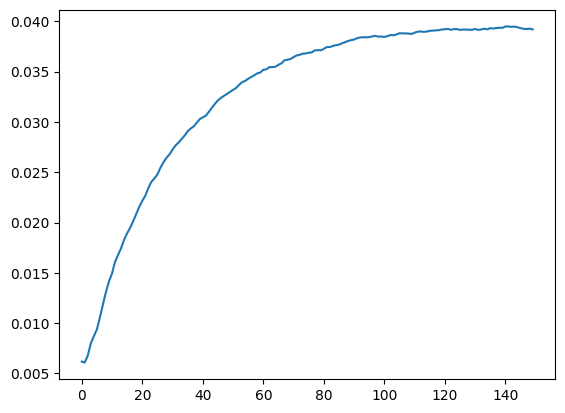

In [11]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

### Готовим данные для сабмита

In [12]:
submit_data = pd.read_csv("/Users/n.anokhin/Downloads/test.csv")
submit_data.head()

,user,track
0,1,4218
1,1,19007
2,1,346
3,1,8822
4,1,29271


In [13]:
filtered_submit_data = submit_data[submit_data["user"].isin(users) & submit_data["track"].isin(tracks)].copy()

In [14]:
filtered_submit_data["score"] = model.predict(
    filtered_submit_data["user"].map(dataset.mapping()[0]).values,
    filtered_submit_data["track"].map(dataset.mapping()[2]).values,
)

<Axes: xlabel='score', ylabel='Count'>

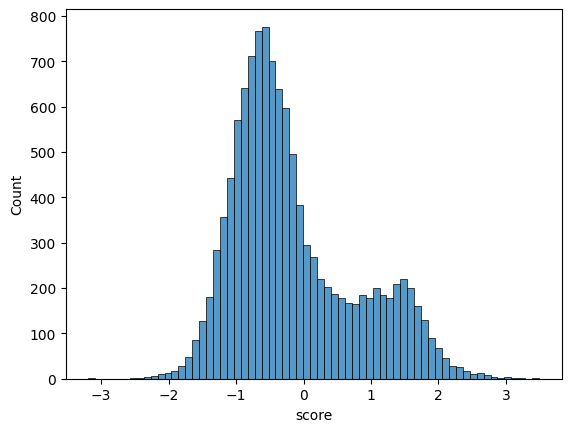

In [25]:
sns.histplot(filtered_submit_data["score"])

In [23]:
scored_submit_data = pd.merge(
    submit_data,
    filtered_submit_data,
    left_on=["user", "track"],
    right_on=["user", "track"],
    how="left"
)

# Fill missing scores with small random numbers
scored_submit_data["score"] = scored_submit_data["score"].map(lambda s : np.random.random() * 0.05 if pd.isna(s) else s)

scored_submit_data.head()

,user,track,score
0,1,4218,0.616859
1,1,19007,0.036949
2,1,346,0.015737
3,1,8822,0.024019
4,1,29271,0.018666


In [26]:
scored_submit_data.to_csv("/Users/n.anokhin/Desktop/submit.csv", index=False)

In [29]:
%%sh 
head /Users/n.anokhin/Desktop/submit.csv

user,track,score
1,4218,0.6168593168258667
1,19007,0.0369488766430307
1,346,0.015736635574270418
1,8822,0.024018909909540427
1,29271,0.018665504832163057
1,43736,0.04012767515694496
3,2298,0.531479001045227
3,837,0.024650016499831347
3,33028,0.0034220831576684653
